In [1]:
# !pip install torch torchvision sentencepiece
# !pip install git+https://github.com/openai/CLIP.git

import torch
from PIL import Image
from torchvision import transforms
from clip import clip
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import PIL
from tqdm import tqdm
import argparse
import pickle

class load_np_dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform):
        self.data = np.load(imgs_path)
        self.targets = np.load(targets_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img , target = self.data[idx], self.targets[idx]
            
        img = PIL.Image.fromarray(img)
        if transform:
            img = self.transform(img)

        return img, target

def parsing():
    parser = argparse.ArgumentParser(description='Tunes a CIFAR Classifier with OE',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--aug', type=str, default='gaussian_noise',
                        help='select noise.')
    parser.add_argument('--batch_size', '-b', type=int,
                        default=64, help='Batch size.')
    parser.add_argument('--seed', type=int, default=1,
                        help='seed')
    parser.add_argument('--num_workers', type=int, 
                        default=0, help='number of workers')
    parser.add_argument('--transform', type=int, 
                        default=0, help='use transformation dataset')

    args = parser.parse_args()
    return args


In [3]:
import sys
sys.argv = ['', '--aug', 'gaussian_noise']

In [29]:

args = parsing()
args.aug = 'spatter'

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)


cifar10_path = '/storage/users/makhavan/CSI/finals/datasets/data/'
cifar10_dataset = CIFAR10(root=cifar10_path, train=True, download=True, transform=transform)

if args.transform:
    cifar_train_cor_img_path = f'/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR-10-Train-R-A/{args.aug}.npy'
    cifar_train_cor_target_path = '/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR-10-Train-R-A/labels-A.npy'
    train_aug_dataset = load_np_dataset(cifar_train_cor_img_path, cifar_train_cor_target_path, transform=transform)
else:
    cifar_train_cor_img_path = f'/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR-10-Train-R-C/{args.aug}.npy'
    cifar_train_cor_target_path = '/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR-10-Train-R-C/labels-C.npy'
    train_aug_dataset = load_np_dataset(cifar_train_cor_img_path, cifar_train_cor_target_path, transform=transform)

cifar10_loader = DataLoader(cifar10_dataset, shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)
aug_loader = DataLoader(train_aug_dataset, shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)



Files already downloaded and verified


TypeError: 'DataLoader' object is not subscriptable

In [31]:
for imgs, target in cifar10_loader:
    break

for imgs_noisy, target_noisy in aug_loader:
    break

In [8]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

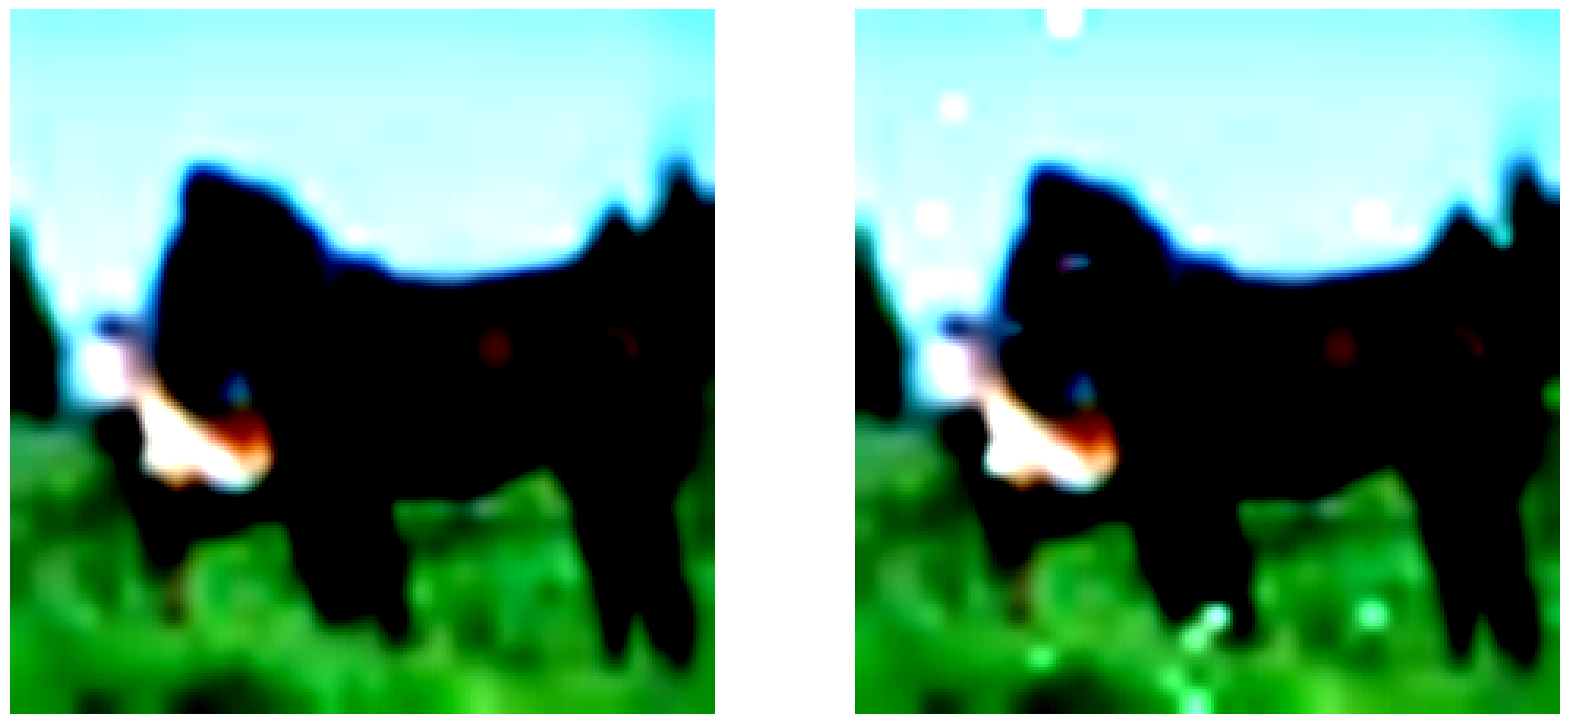

In [33]:
idx = 12
img_ = imgs[idx]
noisy_img_ = imgs_noisy[idx]
fig, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].imshow(img_.permute(1,2,0).detach().numpy())
axis[0].axis('off')
axis[1].imshow(noisy_img_.permute(1,2,0).detach().numpy())
axis[1].axis('off')

In [1]:
import pickle
import numpy as np

In [10]:
with open("./tensors/diffs_gaussian_noise.pkl", 'rb') as f:
    g = pickle.load(f)

with open("./tensors/diffs_target_gaussian_noise.pkl", 'rb') as f:
    t = pickle.load(f)

In [22]:
t, g = zip(*sorted(zip(t, g)))

In [26]:
np.mean(g[:5000])

34.06

In [28]:
for i in range(10):
    print(f"class {i}: {np.mean(g[i*5000:(i+1)*5000])}")

class 0: 34.0625
class 1: 33.3125
class 2: 30.140625
class 3: 30.859375
class 4: 30.21875
class 5: 30.5625
class 6: 25.9375
class 7: 28.453125
class 8: 37.1875
class 9: 34.3125


In [19]:
name = ['Megan', 'Harriet', 'Henry', 'Beth', 'George']
score_list = [9, 6, 5, 6, 10]
score, name = zip(*sorted(zip(score_list, name)))

In [21]:
score, name

((5, 6, 6, 9, 10), ('Henry', 'Beth', 'Harriet', 'Megan', 'George'))

# CLIP CHECK VALUES

In [2]:
import os
dir = "/storage/users/makhavan/CSI/exp09/clip_vec/outputs"

In [42]:
for file_name in os.listdir(dir):
    file_path = os.path.join(dir, file_name)
    with open(file_path, 'r') as f:
        values = []
        lines = f.readlines()
        for line in lines[1:]:
            values.append(float(line.split(':')[1].split('\n')[0]))
            
        print(file_name, np.mean(values), "Min: ", np.min(values), "Max: ", np.max(values), "Max diff: ", np.max(values) - np.min(values))


random_crop.out 22.675 Min:  19.65625 Max:  27.734375 Max diff:  8.078125
rot90.out 29.77265625 Min:  13.4609375 Max:  39.25 Max diff:  25.7890625
gaussian_blur.out 0.843994140625 Min:  0.70556640625 Max:  1.14453125 Max diff:  0.43896484375
gaussian_noise.out 31.5046875 Min:  25.9375 Max:  37.1875 Max diff:  11.25
motion_blur.out 7.82890625 Min:  6.87890625 Max:  9.125 Max diff:  2.24609375
jpeg_compression.out 19.85 Min:  17.1875 Max:  22.21875 Max diff:  5.03125
shot_noise.out 24.603125 Min:  20.484375 Max:  31.1875 Max diff:  10.703125
flip.out 2.7171875 Min:  2.33203125 Max:  3.068359375 Max diff:  0.736328125
brightness.out 0.951123046875 Min:  0.80517578125 Max:  1.068359375 Max diff:  0.26318359375
snow.out 7.005078125 Min:  5.02734375 Max:  9.28125 Max diff:  4.25390625
fog.out 3.483984375 Min:  2.86328125 Max:  5.16796875 Max diff:  2.3046875
glass_blur.out 32.834375 Min:  25.328125 Max:  47.46875 Max diff:  22.140625
elastic_transform.out 13.95234375 Min:  12.125 Max:  15.95

In [1]:
import torch
from PIL import Image
from torchvision import transforms
from clip import clip
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import PIL
from tqdm import tqdm
import argparse
import pickle


device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)


cifar10_path = '/storage/users/makhavan/CSI/finals/datasets/data/'
cifar10_dataset = CIFAR10(root=cifar10_path, train=True, download=True, transform=transform)
cifar10_loader = DataLoader(cifar10_dataset, shuffle=False, batch_size=16)

diffs = []
for i, data in enumerate(cifar10_loader):
    imgs_n, targets = data
    # imgs_n, imgs_aug = transform(imgs_n).to(device), transform(imgs_aug).to(device)
    imgs_n = imgs_n.to(device)
    imgs_n_features = model.encode_image(imgs_n)
    diffs.extend(imgs_n_features.detach().cpu().numpy())


Files already downloaded and verified


NameError: name 'args' is not defined